# Conditional DCGAN

In [3]:
import torch
from torch import nn
import torch.nn.parallel
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from svlearn.gans import config , Task
from svlearn.gans.dcgan_models import DigitGenerator
from svlearn.gans.conditional_dcgan import ConditionalGenerator
from svlearn.gans.dcgan_datasets import load_mnist_dataset
from svlearn.gans.gan_trainer import load_checkpoint

In [4]:
task = Task.MNIST.value
data_dir = config[task]['data']
results_dir=config[task]['results']


In [5]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Global variables
# Number of channels in the training images. For color images this is 3
nc = config[task]['num_channels']

# Size of z latent vector (i.e. size of generator input)
nz = config[task]['nz']

# Size of feature maps in generator
ngf = config[task]['ngf']

# Size of feature maps in discriminator
ndf = config[task]['ndf']

# number of classes of training images
num_classes = config[task]['num_classes']

# Decide which device we want to run on
device =  torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")    


In [6]:
dataset = load_mnist_dataset()

# Create the dataloader
if batch_size == -1:
        batch_size = len(dataset)
        
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

In [7]:
classes = dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [20]:
# Create the Generator and Discriminator
generator = DigitGenerator(nz, ngf, nc, ngpu=ngpu ).to(device)
netG = ConditionalGenerator(generator, ngpu, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

Display sample images along with their labels

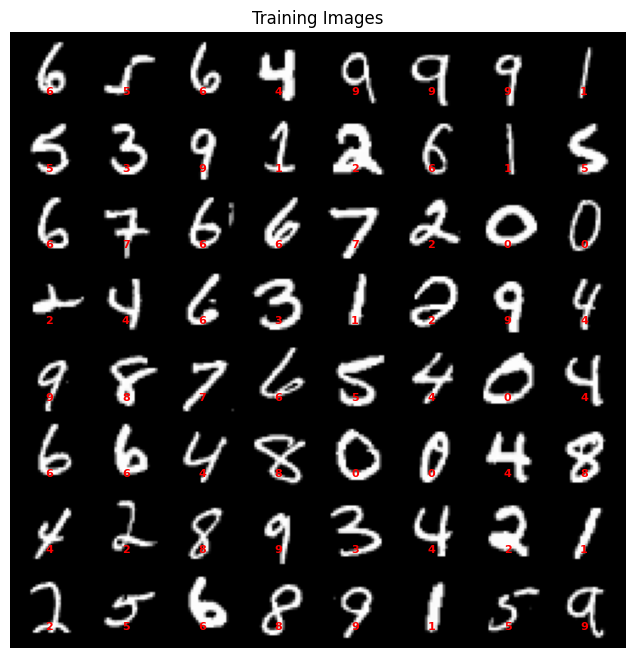

In [24]:

# Plot some training images
# Get a batch of images and labels
real_batch = next(iter(dataloader))
images, labels = real_batch[0].to(device), real_batch[1].cpu().numpy()  # Convert labels to numpy array for easier handling

# Create a grid of images
grid = vutils.make_grid(images[:64], padding=2, normalize=True)
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))  # Transpose to (H, W, C) format for plotting

# Plot the grid
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)

# Add labels to each image
grid_size = int(np.sqrt(64))  # Assuming a 8x8 grid for 64 images
img_size = grid.shape[0] // grid_size  # Calculate size of each image in the grid
for i in range(64):
    row = i // grid_size
    col = i % grid_size
    # Position text at the bottom center of each image
    plt.text(col * img_size + img_size / 2, row * img_size + img_size - 5,
             str(classes[labels[i]][0]), ha="center", va="bottom", color="red", fontsize=8, weight='bold')

plt.show()

Load the already trained conditional DCGAN

In [26]:
checkpoint_generator_file = f'{results_dir}/conditional_generator_01.pt'
load_checkpoint(netG , checkpoint_generator_file)


/home/devops/kayal/ai-intro/src/svlearn/gans/gan_trainer.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dis = torch.load(checkpoint_file)


ConditionalGenerator(
  (generator): DigitGenerator(
    (first_layer): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (subsequent_layers): Sequential(
      (0): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(56, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (9): Tanh()
    )
    (main): Sequential(
      (0): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (1): Sequential(
        (0): Batch

In [27]:
gen_checkpoint = torch.load(f'{results_dir}/conditional_generator_01.pt')
results = gen_checkpoint["results"]
epoch = gen_checkpoint["epoch"]
print(f'Epoch with best metrics is {epoch}')

Epoch with best metrics is 499


/tmp/ipykernel_360451/677067444.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_checkpoint = torch.load(f'{results_dir}/conditional_generator_01.pt')


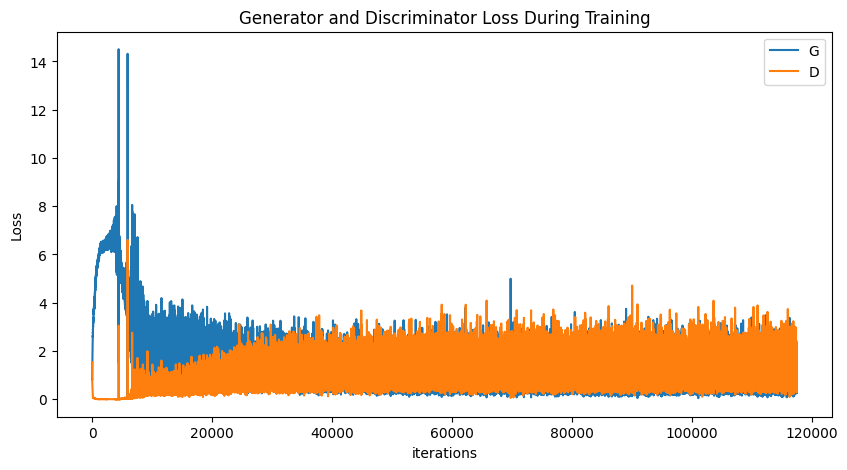

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results["gen loss"],label="G")
plt.plot(results["dis loss"],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
netG.eval()

ConditionalGenerator(
  (generator): DigitGenerator(
    (first_layer): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (subsequent_layers): Sequential(
      (0): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): ConvTranspose2d(56, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (9): Tanh()
    )
    (main): Sequential(
      (0): ConvTranspose2d(110, 224, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (1): Sequential(
        (0): Batch

Add image labels of 0 to the noise to generate images with "Oak" conditioning

In [ ]:
# Size of z latent vector (i.e. size of generator input)
nz = 100
# size of the test batch
test_batch_size = 16
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(test_batch_size, nz, 1, 1, device=device)
image_labels = torch.zeros(test_batch_size, dtype=torch.long).to(device)

with torch.no_grad():
    fake = netG(noise, image_labels).cpu()
image_grid = vutils.make_grid(fake, padding=2, normalize=True)

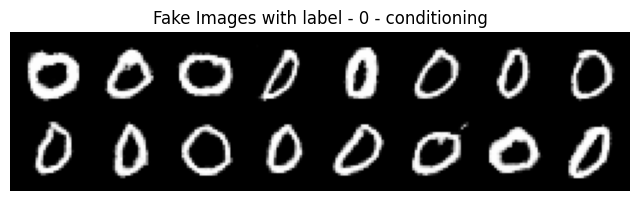

In [32]:
# Plot the fake images generated from noise
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images with label - 0 - conditioning")
plt.imshow(np.transpose(image_grid,(1,2,0)))
plt.show()

Add image labels of 1's to the noise vector to generate images with "Weeping Willow" conditioning

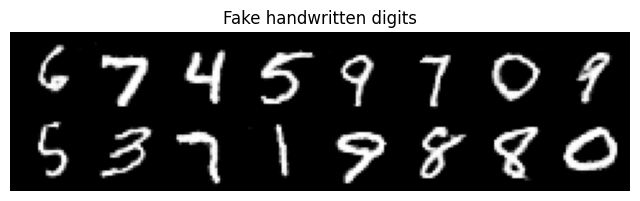

tensor([6, 7, 4, 5, 9, 7, 0, 9, 5, 3, 7, 1, 9, 8, 8, 0], device='cuda:0')

In [33]:
# Create batch of latent vectors that we will use to visualize the generator
noise = torch.randn(test_batch_size, nz, 1, 1, device=device)
image_labels = torch.randint(0, 10, (test_batch_size,1), dtype=torch.long).to(device).view(-1)


with torch.no_grad():
    fake = netG(noise, image_labels).cpu()
image_grid = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the fake images generated from noise
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake handwritten digits")
plt.imshow(np.transpose(image_grid,(1,2,0)))
plt.show()
image_labels